In [2]:
# Import necessary libraries
import os
os.chdir('/lustre/scratch/aylar/integer')
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import harmonypy as hm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read input datasets
adata1 = sc.read("leiden_without_HVG_MARKER_GSE207422.h5ad")
adata2 = sc.read("leiden_without_HVG_MARKER_NTB_GSE131907.h5ad")

# Assign batch labels for both datasets
adata1.obs["batch"] = "batch1"
adata2.obs["batch"] = "batch2"

In [3]:
# Concatenate datasets, keeping track of batches
adata = adata1.concatenate(adata2, batch_key="batch", index_unique="-")
adata.obs.head()

Sample Patient   Sex   Age Pathology PD1 Antibody  \
BD_immune01_612637-0  BD_immune01     P01  Male  68.0  Squamous  Toripalimab   
BD_immune01_698718-0  BD_immune01     P01  Male  68.0  Squamous  Toripalimab   
BD_immune01_509246-0  BD_immune01     P01  Male  68.0  Squamous  Toripalimab   
BD_immune01_101435-0  BD_immune01     P01  Male  68.0  Squamous  Toripalimab   
BD_immune01_400370-0  BD_immune01     P01  Male  68.0  Squamous  Toripalimab   

                               Chemotherapy Pathologic Response  \
BD_immune01_612637-0  Carboplatin+Docetaxel                  NE   
BD_immune01_698718-0  Carboplatin+Docetaxel                  NE   
BD_immune01_509246-0  Carboplatin+Docetaxel                  NE   
BD_immune01_101435-0  Carboplatin+Docetaxel                  NE   
BD_immune01_400370-0  Carboplatin+Docetaxel                  NE   

                     Residual Tumor RECIST  ...  total_counts  percent_mito  \
BD_immune01_612637-0             NE     SD  ...       45924.0      0.066675   
BD_immune01_698718-0             NE     SD  ...       41596.0      0.042504   
BD_immune01_509246-0             NE     SD  ...       31883.0      0.170153   
BD_immune01_101435-0             NE     SD  ...       31458.0      0.069871   
BD_immune01_400370-0             NE     SD  ...        9912.0      0.108253   

                      percent_ribo  leiden batch Barcode Sample_Origin  \
BD_immune01_612637-0      0.110596       5     0     NaN           NaN   
BD_immune01_698718-0      0.133498       5     0     NaN           NaN   
BD_immune01_509246-0      0.062228       5     0     NaN           NaN   
BD_immune01_101435-0      0.087927       5     0     NaN           NaN   
BD_immune01_400370-0      0.128935       0     0     NaN           NaN   

                     Cell_type Cell_type.refined Cell_subtype  
BD_immune01_612637-0       NaN               NaN          NaN  
BD_immune01_698718-0       NaN               NaN          NaN  
BD_immune01_509246-0       NaN               NaN          NaN  
BD_immune01_101435-0       NaN               NaN          NaN  
BD_immune01_400370-0       NaN               NaN          NaN  

[5 rows x 21 columns]

In [4]:
# Normalize total counts to 10,000 per cell
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat')

In [5]:
# PCA & neighbors
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

In [9]:
sc.tl.leiden(adata, resolution=0.05)
# Count total Leiden clusters
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 12


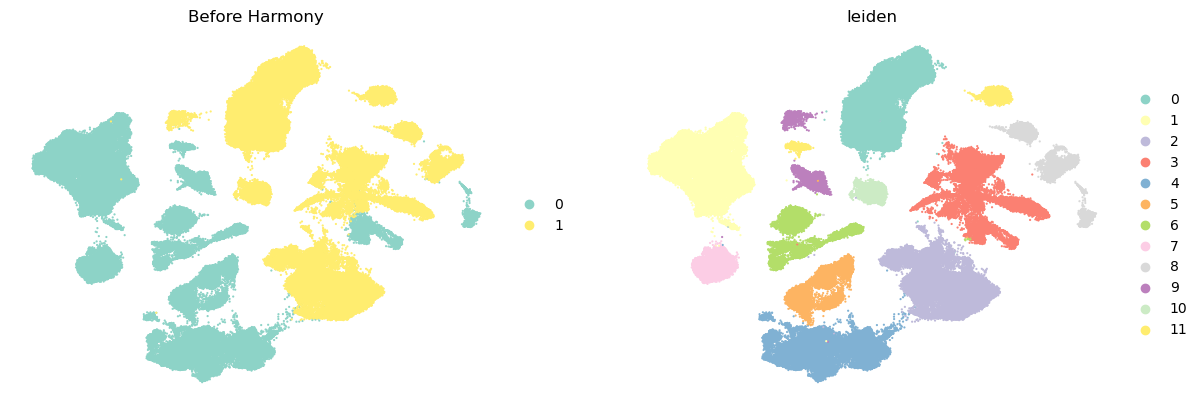

In [10]:
# Plot UMAP before Harmony, colored by batch and cluster
sc.pl.umap(adata, color=["batch", "leiden"], title="Before Harmony", size=10, frameon=False,  show=False, palette='Set3')
plt.tight_layout()
plt.savefig("INT_w_before_harmony.png", dpi=300)
plt.show() 

In [11]:
# Perform batch correction using Harmony
harmony_results = hm.run_harmony(
    data_mat=adata.obsm["X_pca"],   # PCA embeddings
    meta_data=adata.obs,            # Metadata (obs dataframe)
    vars_use=["batch"]               # Correct for batch variable
)

# Fix the shape of the Harmony-corrected embeddings
adata.obsm["X_pca_harmony"] = harmony_results.Z_corr.T  

# Compute neighbors and clustering using the Harmony-corrected PCA embeddings
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)

2025-03-28 10:22:04,335 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-28 10:23:17,254 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-28 10:23:20,914 - harmonypy - INFO - Iteration 1 of 10
2025-03-28 10:29:12,300 - harmonypy - INFO - Iteration 2 of 10
2025-03-28 10:36:02,964 - harmonypy - INFO - Iteration 3 of 10
2025-03-28 10:42:44,729 - harmonypy - INFO - Iteration 4 of 10
2025-03-28 10:49:23,904 - harmonypy - INFO - Iteration 5 of 10
2025-03-28 10:54:29,628 - harmonypy - INFO - Converged after 5 iterations


In [13]:
sc.tl.leiden(adata, resolution=0.1)

# Number of clusters after Harmony
num_clusters_after = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters after Harmony: {num_clusters_after}")

Number of Leiden clusters after Harmony: 10


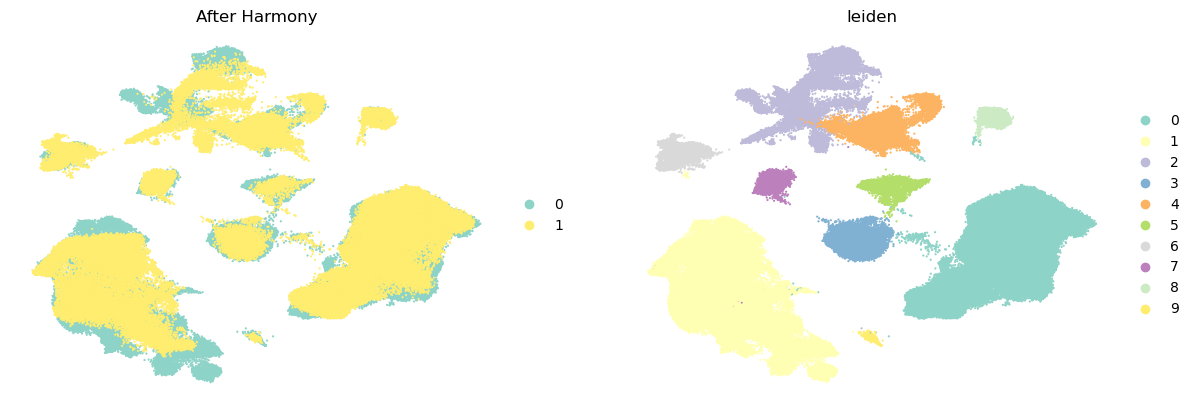

In [15]:
# Plot UMAP before Harmony, colored by batch and cluster
sc.pl.umap(adata, color=["batch", "leiden"], title="After Harmony", size=10, frameon=False,  show=False, palette='Set3')
plt.tight_layout()
plt.savefig("INT_w_after_harmony.png", dpi=300)
plt.show() 

In [16]:
adata.write("Harmony_w_INT.h5ad")

In [17]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

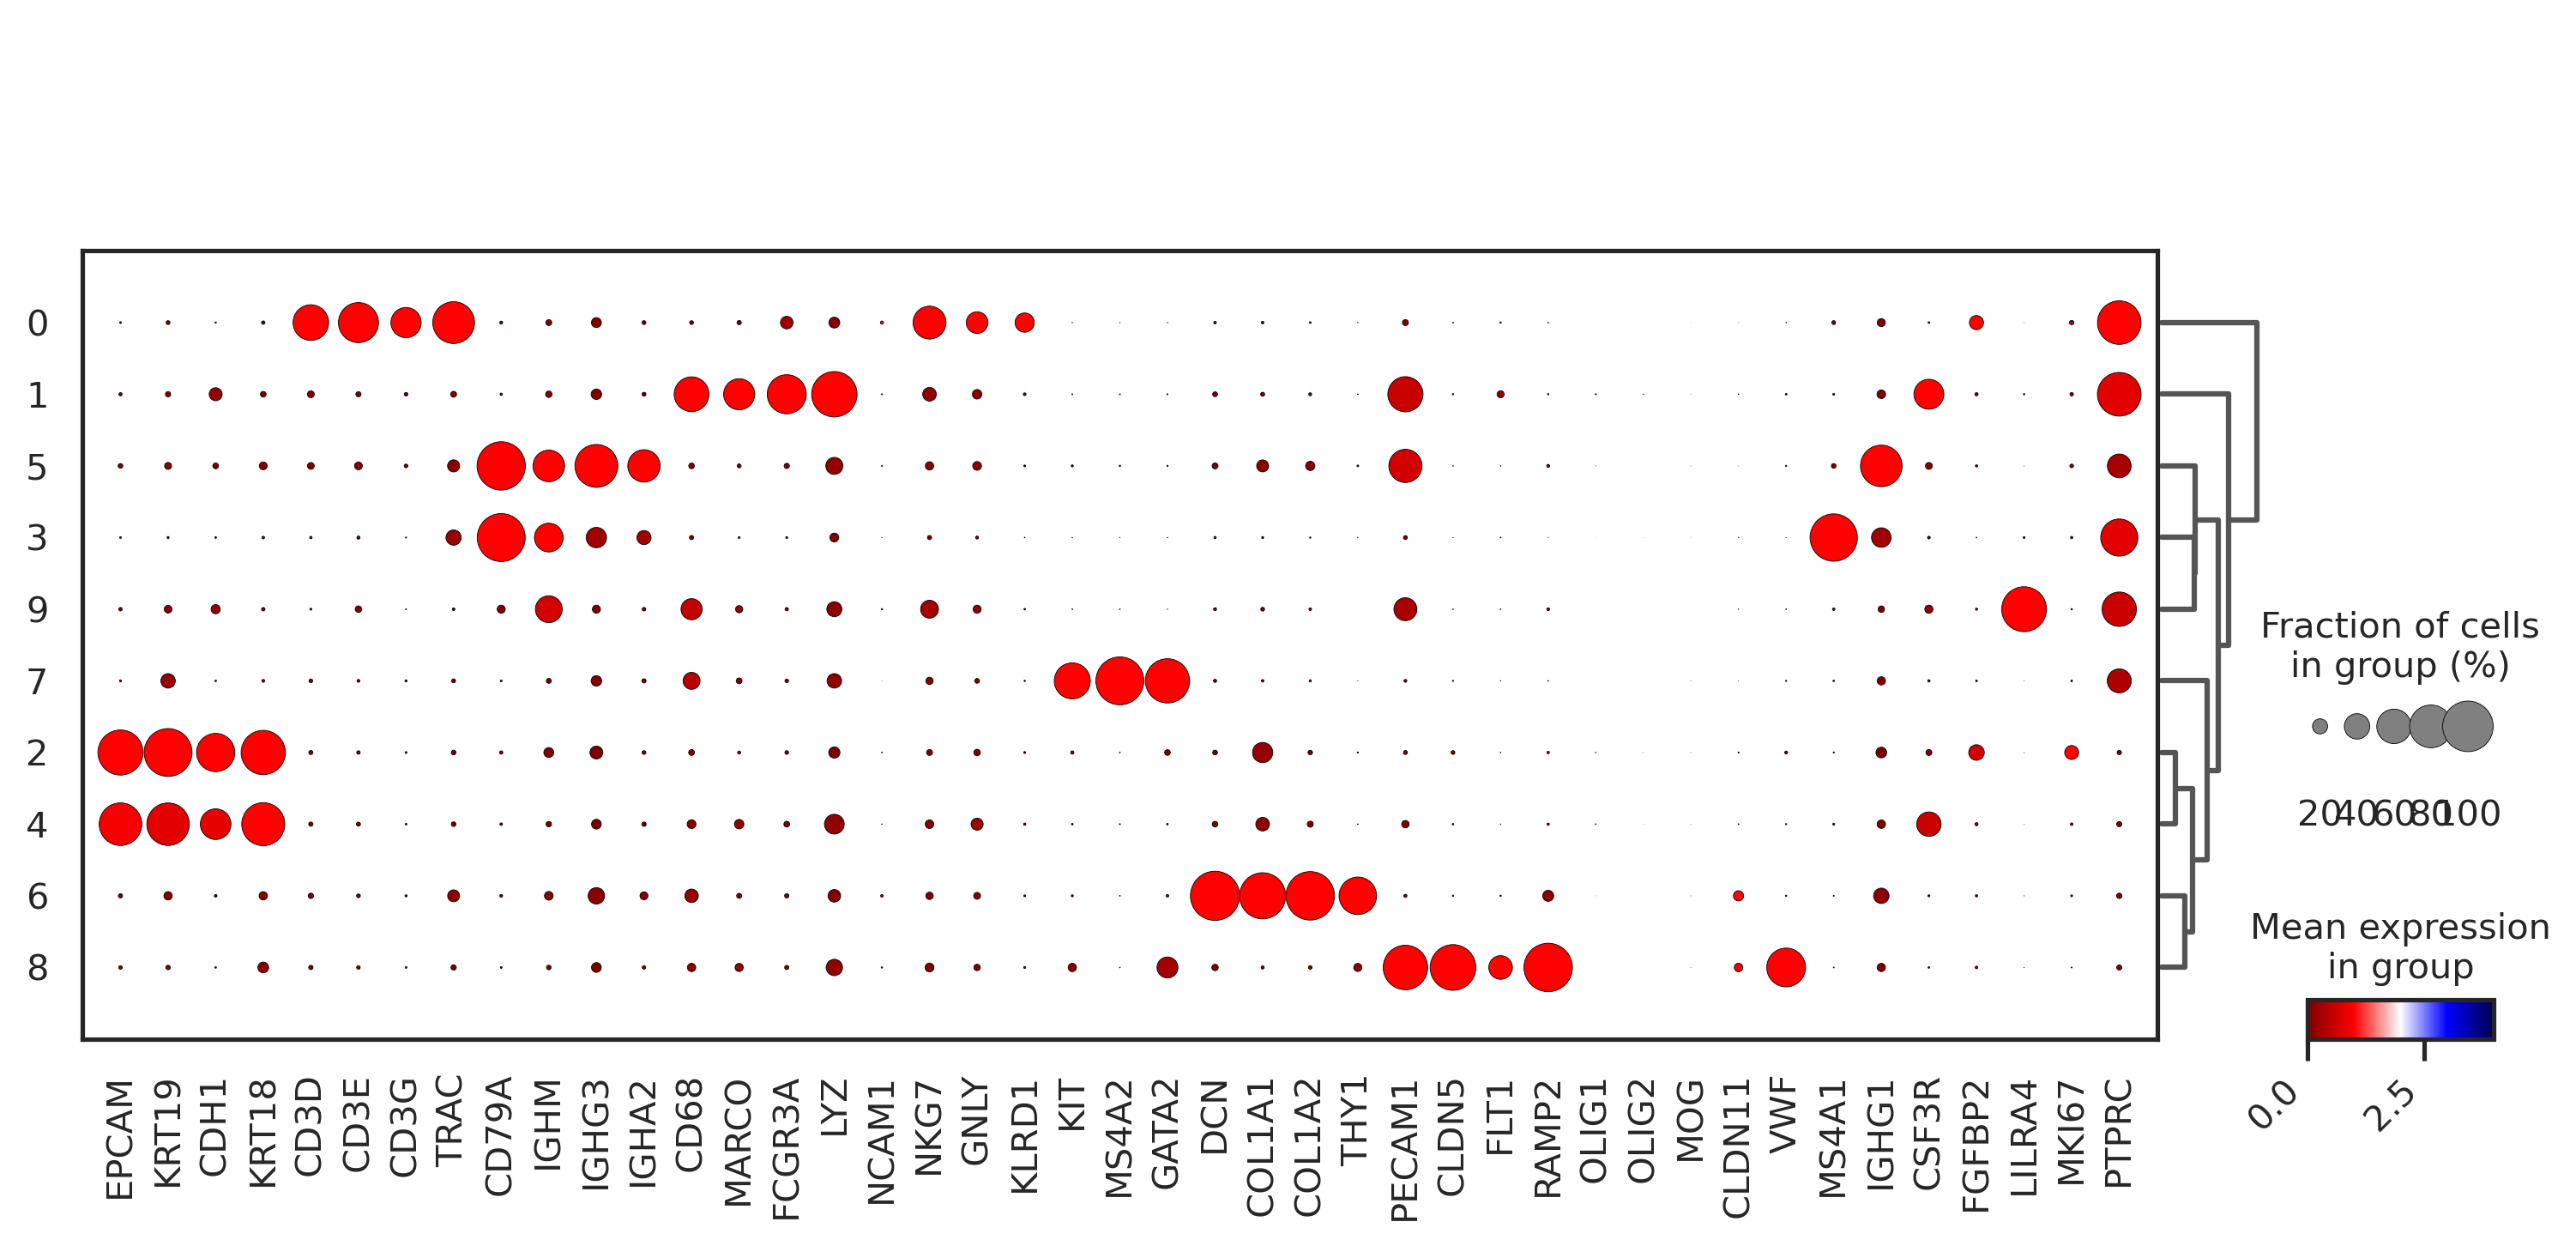

In [18]:
marker_genes = [
    'EPCAM', 'KRT19', 'CDH1', 'KRT18', 'CD3D', 'CD3E', 'CD3G', 'TRAC', 
    'CD79A', 'IGHM', 'IGHG3', 'IGHA2', 'CD68', 'MARCO', 'FCGR3A', 'LYZ', 
    'NCAM1', 'NKG7', 'GNLY', 'KLRD1', 'KIT', 'MS4A2', 'GATA2', 'DCN', 
    'COL1A1', 'COL1A2', 'THY1', 'PECAM1', 'CLDN5', 'FLT1', 'RAMP2', 
    'OLIG1', 'OLIG2', 'MOG', 'CLDN11','VWF', 'MS4A1', 'IGHG1', 'CSF3R',
    'FGFBP2','LILRA4','MKI67','PTPRC'
]
marker= [gene for gene in marker_genes if gene in adata.var_names]
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.dotplot(adata,  marker, groupby='leiden', dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)
 
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dot_w_cell_type.png", dpi=300)
plt.show()

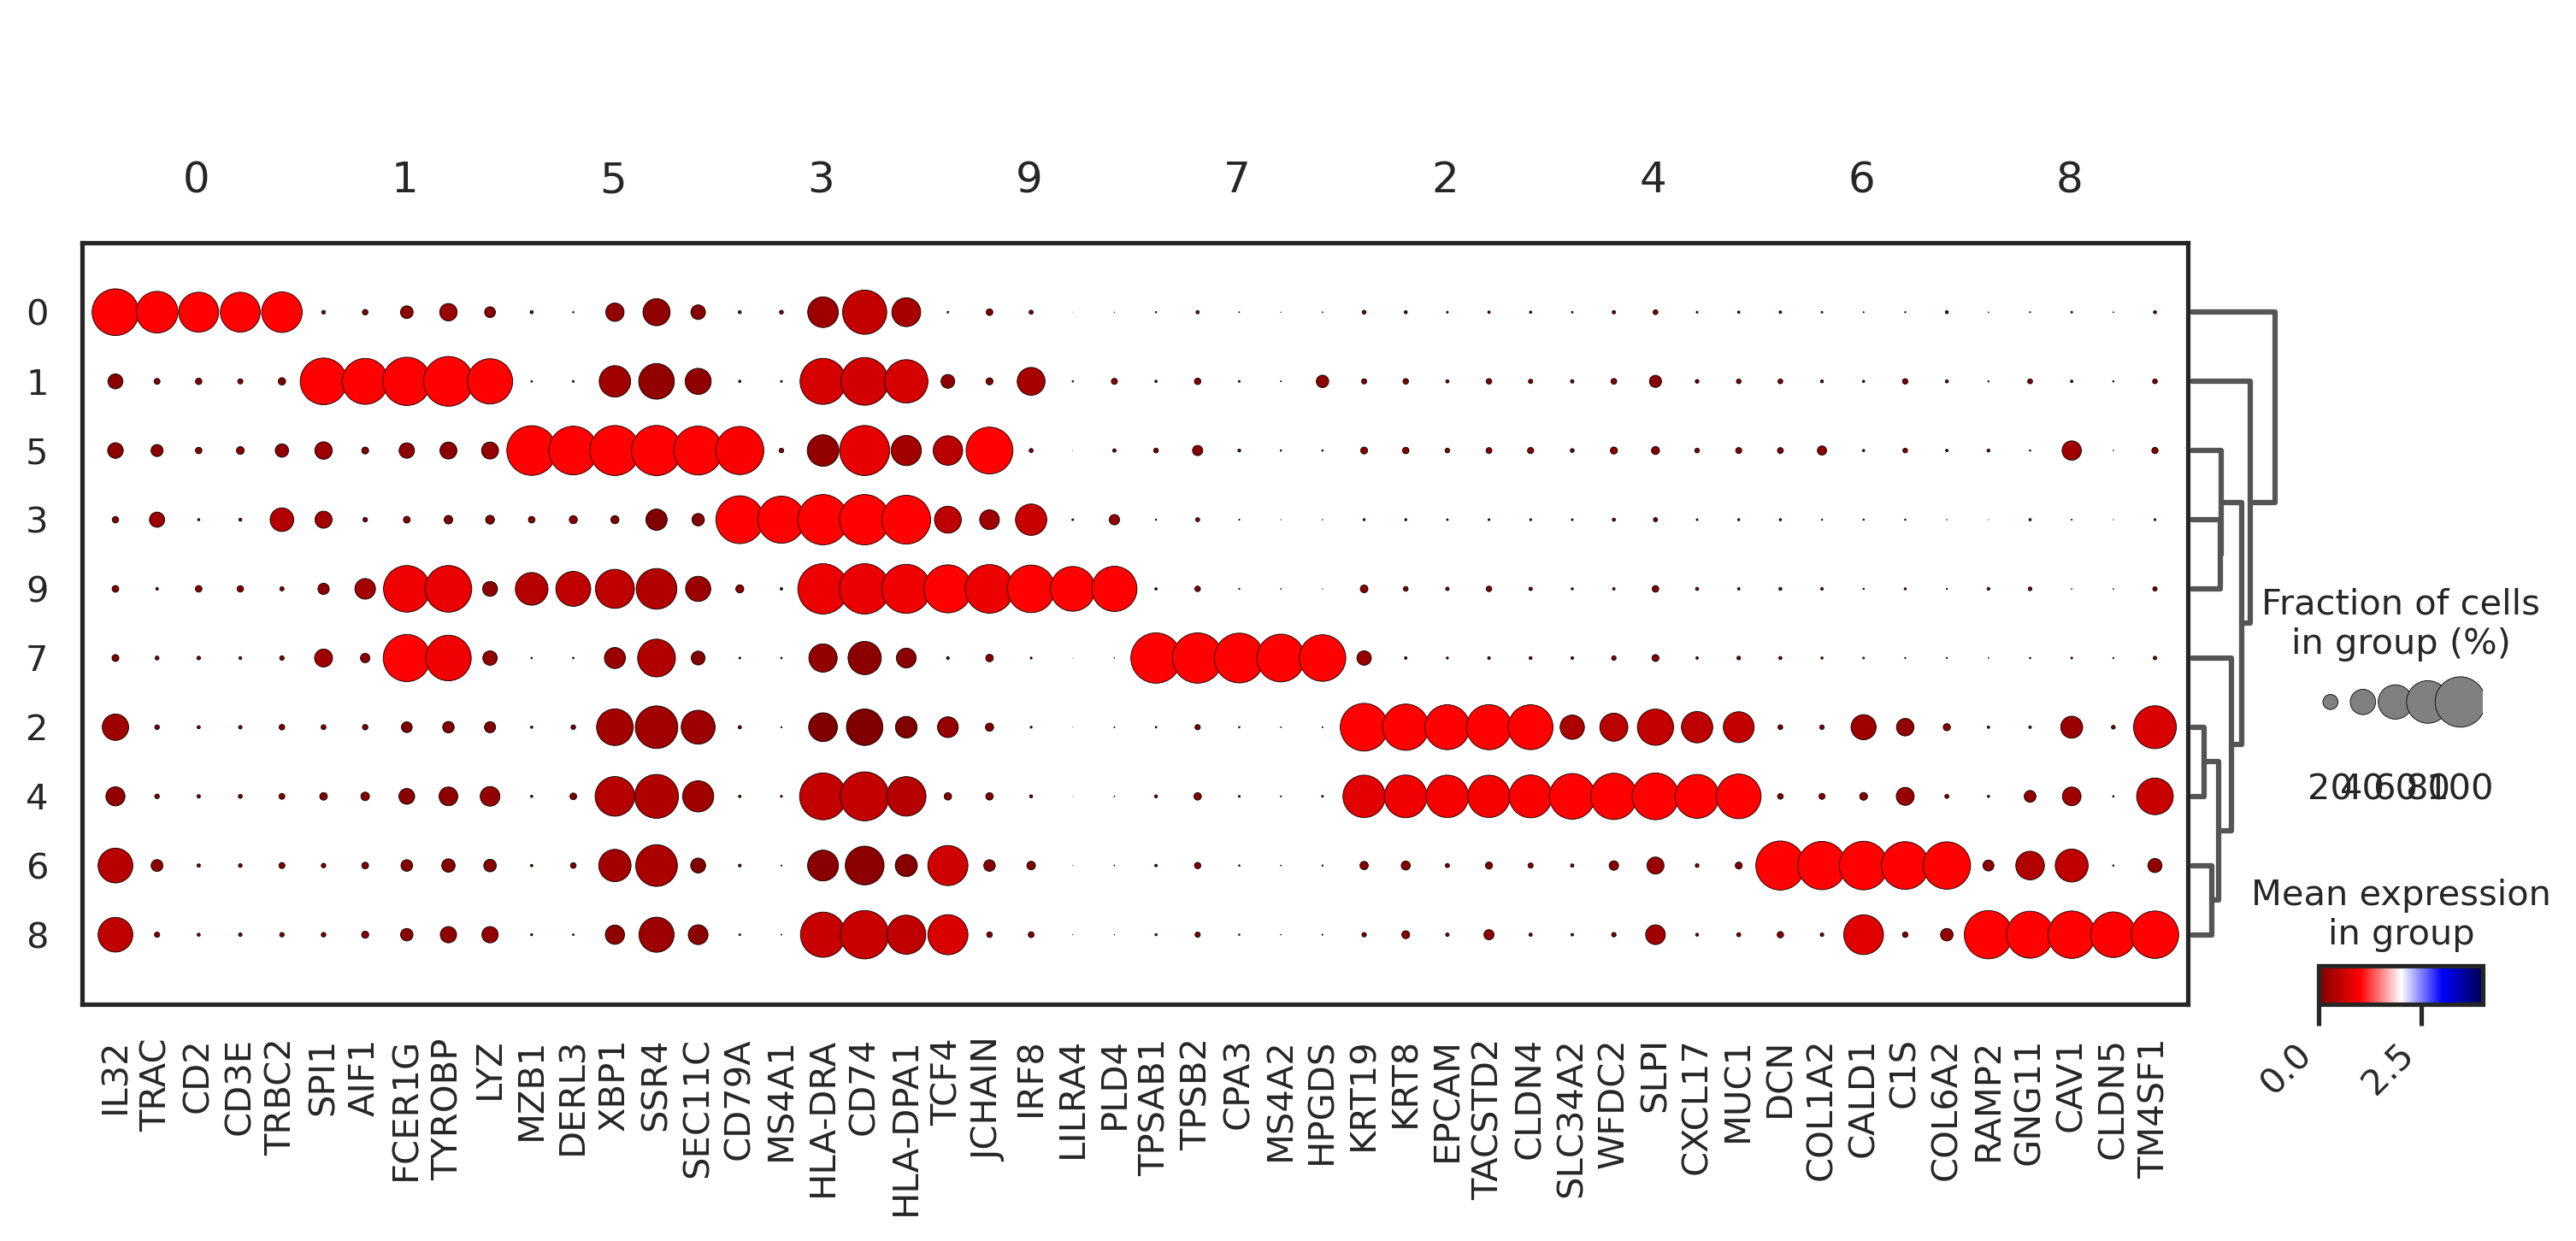

In [19]:
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,  groupby='leiden', n_genes=5, dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot_w_cell_type2.png", dpi=300)
plt.show()

In [21]:
ranked_genes = adata.uns['rank_genes_groups']
top_genes = {}
for cluster in ranked_genes['names'].dtype.names:  
    top_genes[cluster] = ranked_genes['names'][cluster][:5]  
for cluster, genes in top_genes.items():
    print(f"Cluster {cluster}: {', '.join(genes)}")

Cluster 0: IL32, TRAC, CD2, CD3E, TRBC2
Cluster 1: SPI1, AIF1, FCER1G, TYROBP, LYZ
Cluster 2: KRT19, KRT8, EPCAM, TACSTD2, CLDN4
Cluster 3: CD79A, MS4A1, HLA-DRA, CD74, HLA-DPA1
Cluster 4: SLC34A2, WFDC2, SLPI, CXCL17, MUC1
Cluster 5: MZB1, DERL3, XBP1, SSR4, SEC11C
Cluster 6: DCN, COL1A2, CALD1, C1S, COL6A2
Cluster 7: TPSAB1, TPSB2, CPA3, MS4A2, HPGDS
Cluster 8: RAMP2, GNG11, CAV1, CLDN5, TM4SF1
Cluster 9: TCF4, JCHAIN, IRF8, LILRA4, PLD4


In [22]:
cluster_to_cell = {
    0: "T cells",
    1: "Myeloid",
    2: "Epithelial",
    3: "B Cells",
    4: "Epithelial",
    5: "B Cells",
    6: "Fibroblast",
    7: "Mast cells",
    8: "Endothelial",
    9: "pDCs"
}

adata.obs['leiden'] = adata.obs['leiden'].astype(int)
adata.obs['cell'] = adata.obs['leiden'].map(cluster_to_cell)
adata.obs[['leiden', 'cell']].head()

leiden        cell
BD_immune01_612637-0       2  Epithelial
BD_immune01_698718-0       2  Epithelial
BD_immune01_509246-0       2  Epithelial
BD_immune01_101435-0       2  Epithelial
BD_immune01_400370-0       0     T cells

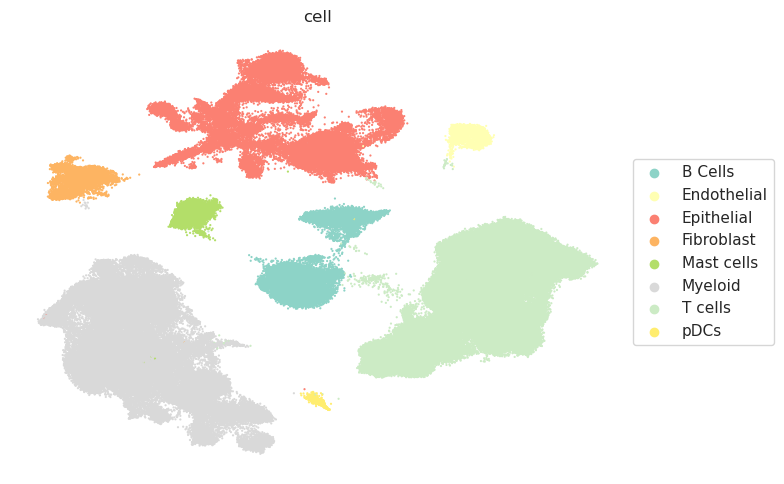

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))  # Set figure size
sc.pl.umap(adata, color="cell", size=10, frameon=False, ax=ax, show=False, palette='Set3')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("inte_w_cell.png", dpi=300)
plt.show()

In [25]:
adata.write("cell_w_INT.h5ad")

In [85]:
adata=sc.read("cell_w_INT.h5ad")

In [86]:
adata = adata[adata.obs['cell'] == 'Epithelial'].copy()

In [87]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)

In [94]:
sc.tl.leiden(adata, resolution=0.02)
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 8


In [96]:
adata.write("epi_w_INT.h5ad")

In [149]:
adata=sc.read("epi_w_INT.h5ad")

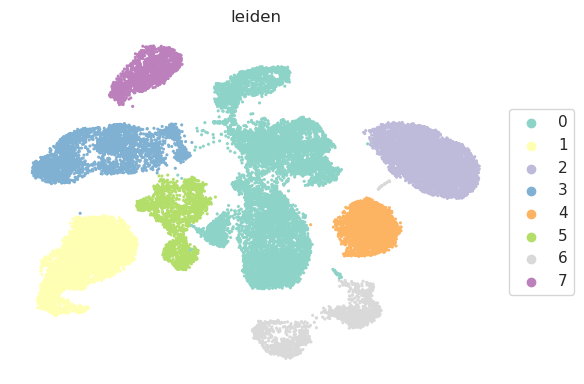

In [95]:
fig, ax = plt.subplots(figsize=(6, 4))  # Set figure size
sc.pl.umap(adata, color="leiden", size=20, frameon=False, ax=ax, show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("cell_epi_w_INT.png", dpi=300)
plt.show()

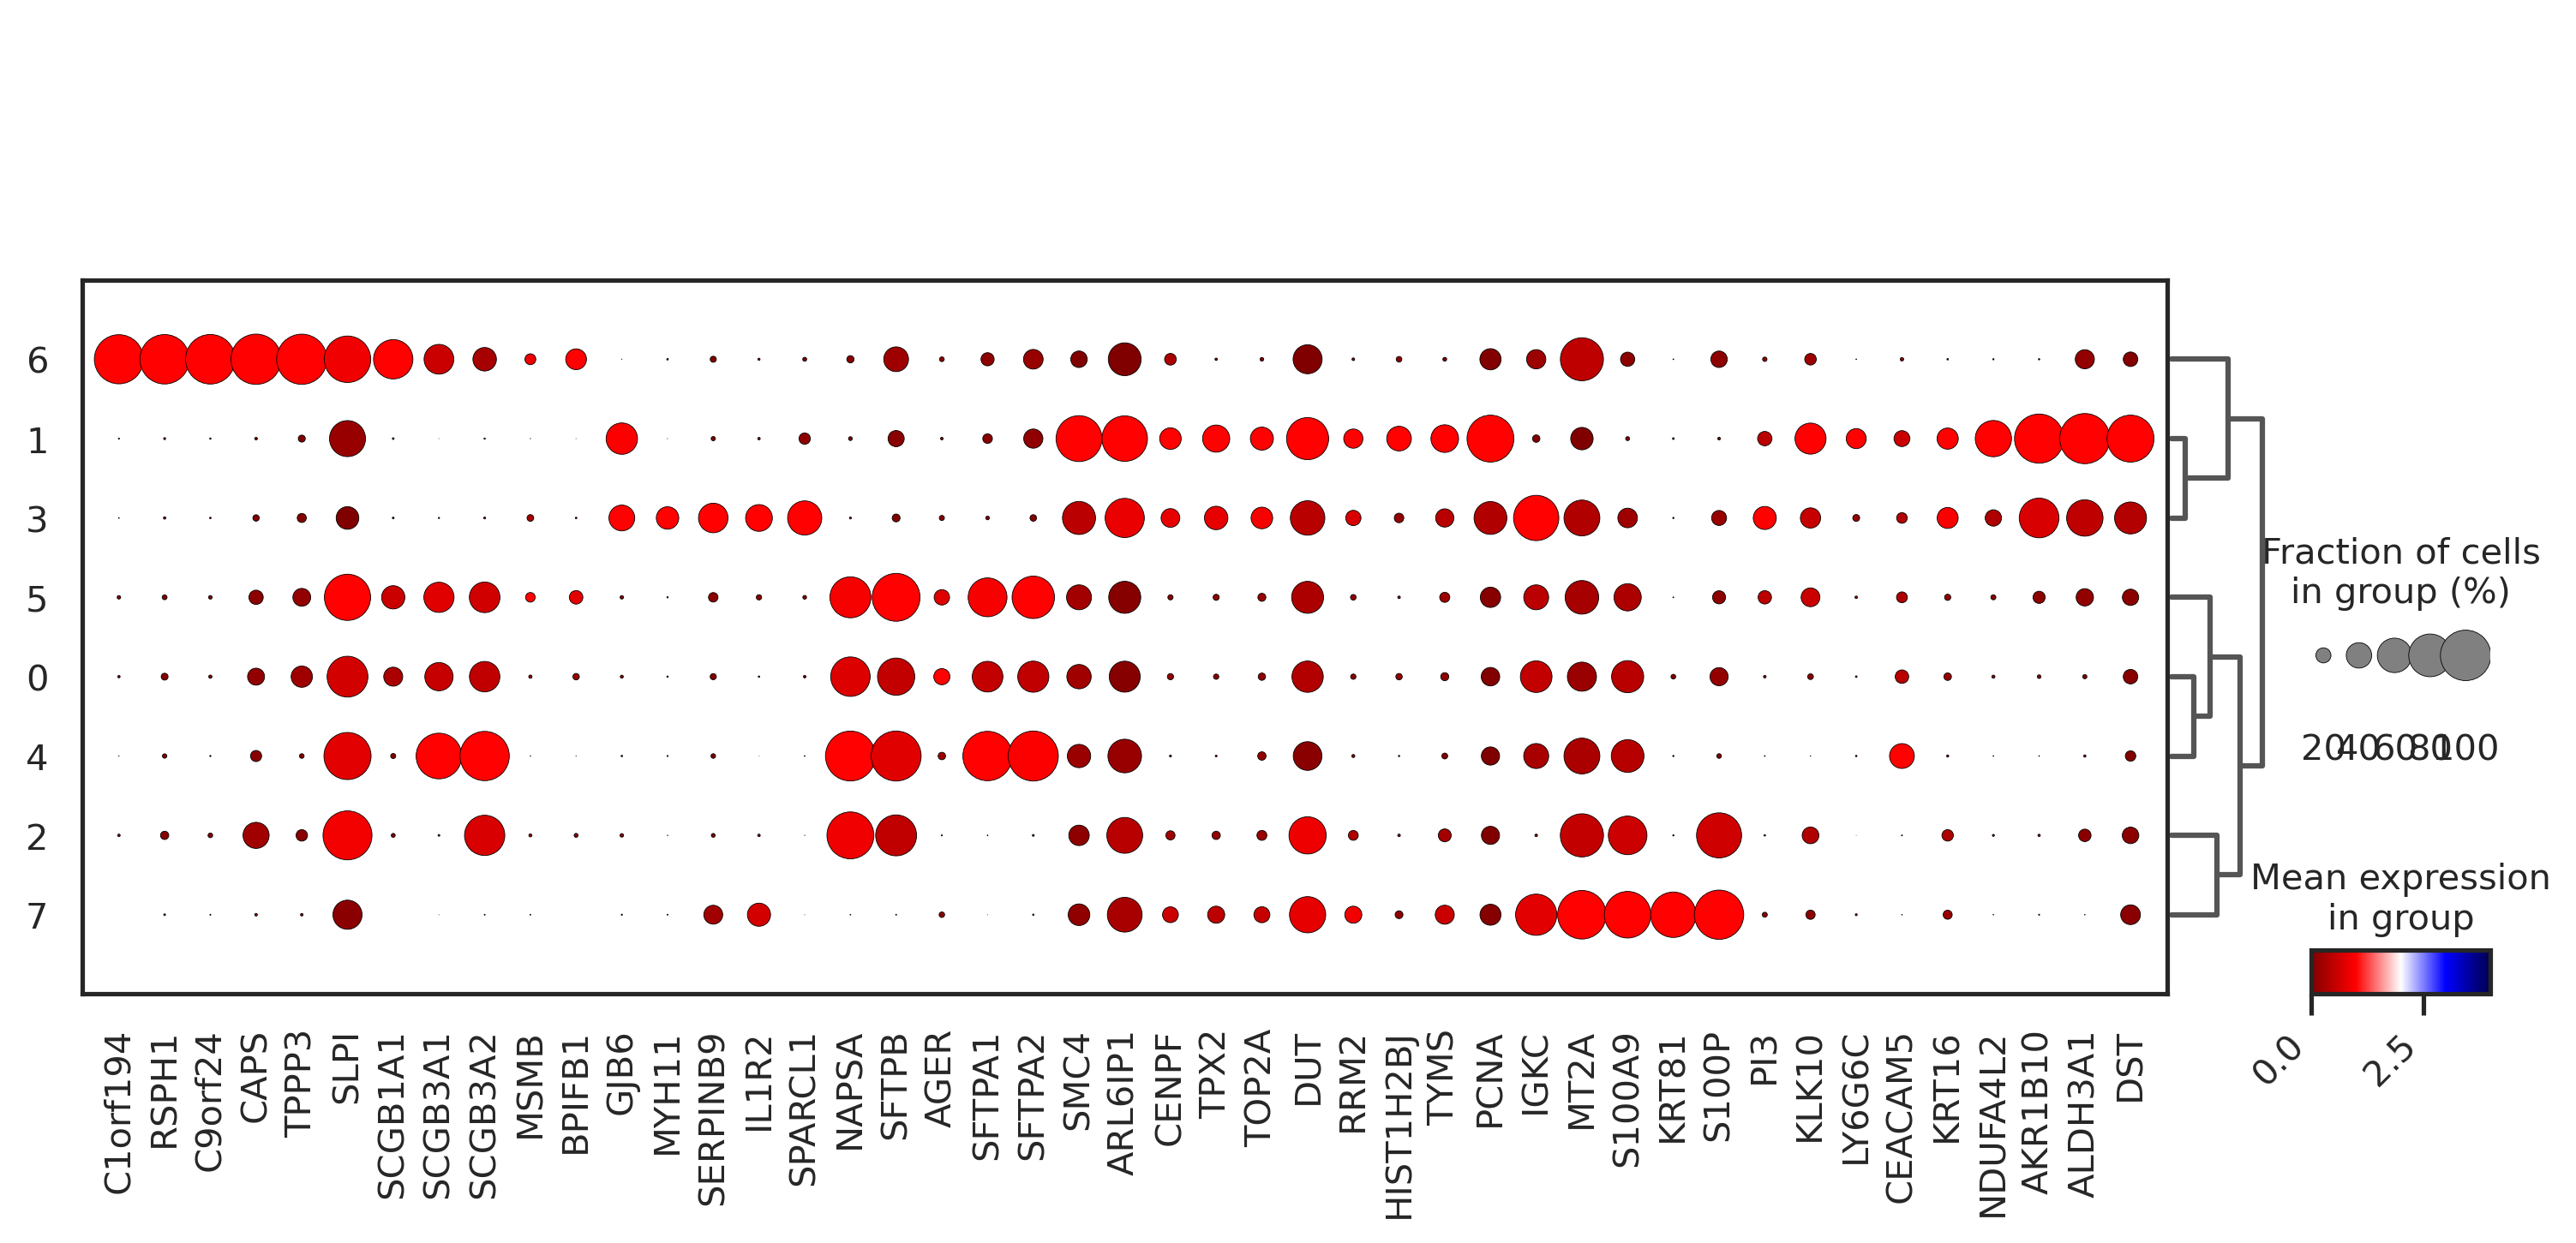

In [97]:
marker_epi= ["C1orf194", "RSPH1", "C9orf24", "CAPS", "TPPP3", "SLPI","SCGB1A1",
"SCGB3A1", "SCGB3A2", "MSMB", "BPIFB1", "GJB6", "MYH11", "AL365357.1", "SERPINB9", "IL1R2",
"SPARCL1", "NAPSA", "SFTPB", "AGER","SFTPA1","SFTPA2", "SMC4", "ARL6IP1",
"CENPF","TPX2", "TOP2A", "DUT","RRM2","HIST1H2BJ","TYMS", "PCNA","IGKC","MT2A",
"S100A9","KRT81","S100P","PI3","KLK10","LY6G6C","CEACAM5","KRT16","NDUFA4L2","AKR1B10","NMRAL2P","ALDH3A1", "DST"]

marker= [gene for gene in marker_epi if gene in adata.var_names]

sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.dotplot(adata,  marker, groupby='leiden', dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot_w_suptype_INT.png", dpi=300)
plt.show()

In [150]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')


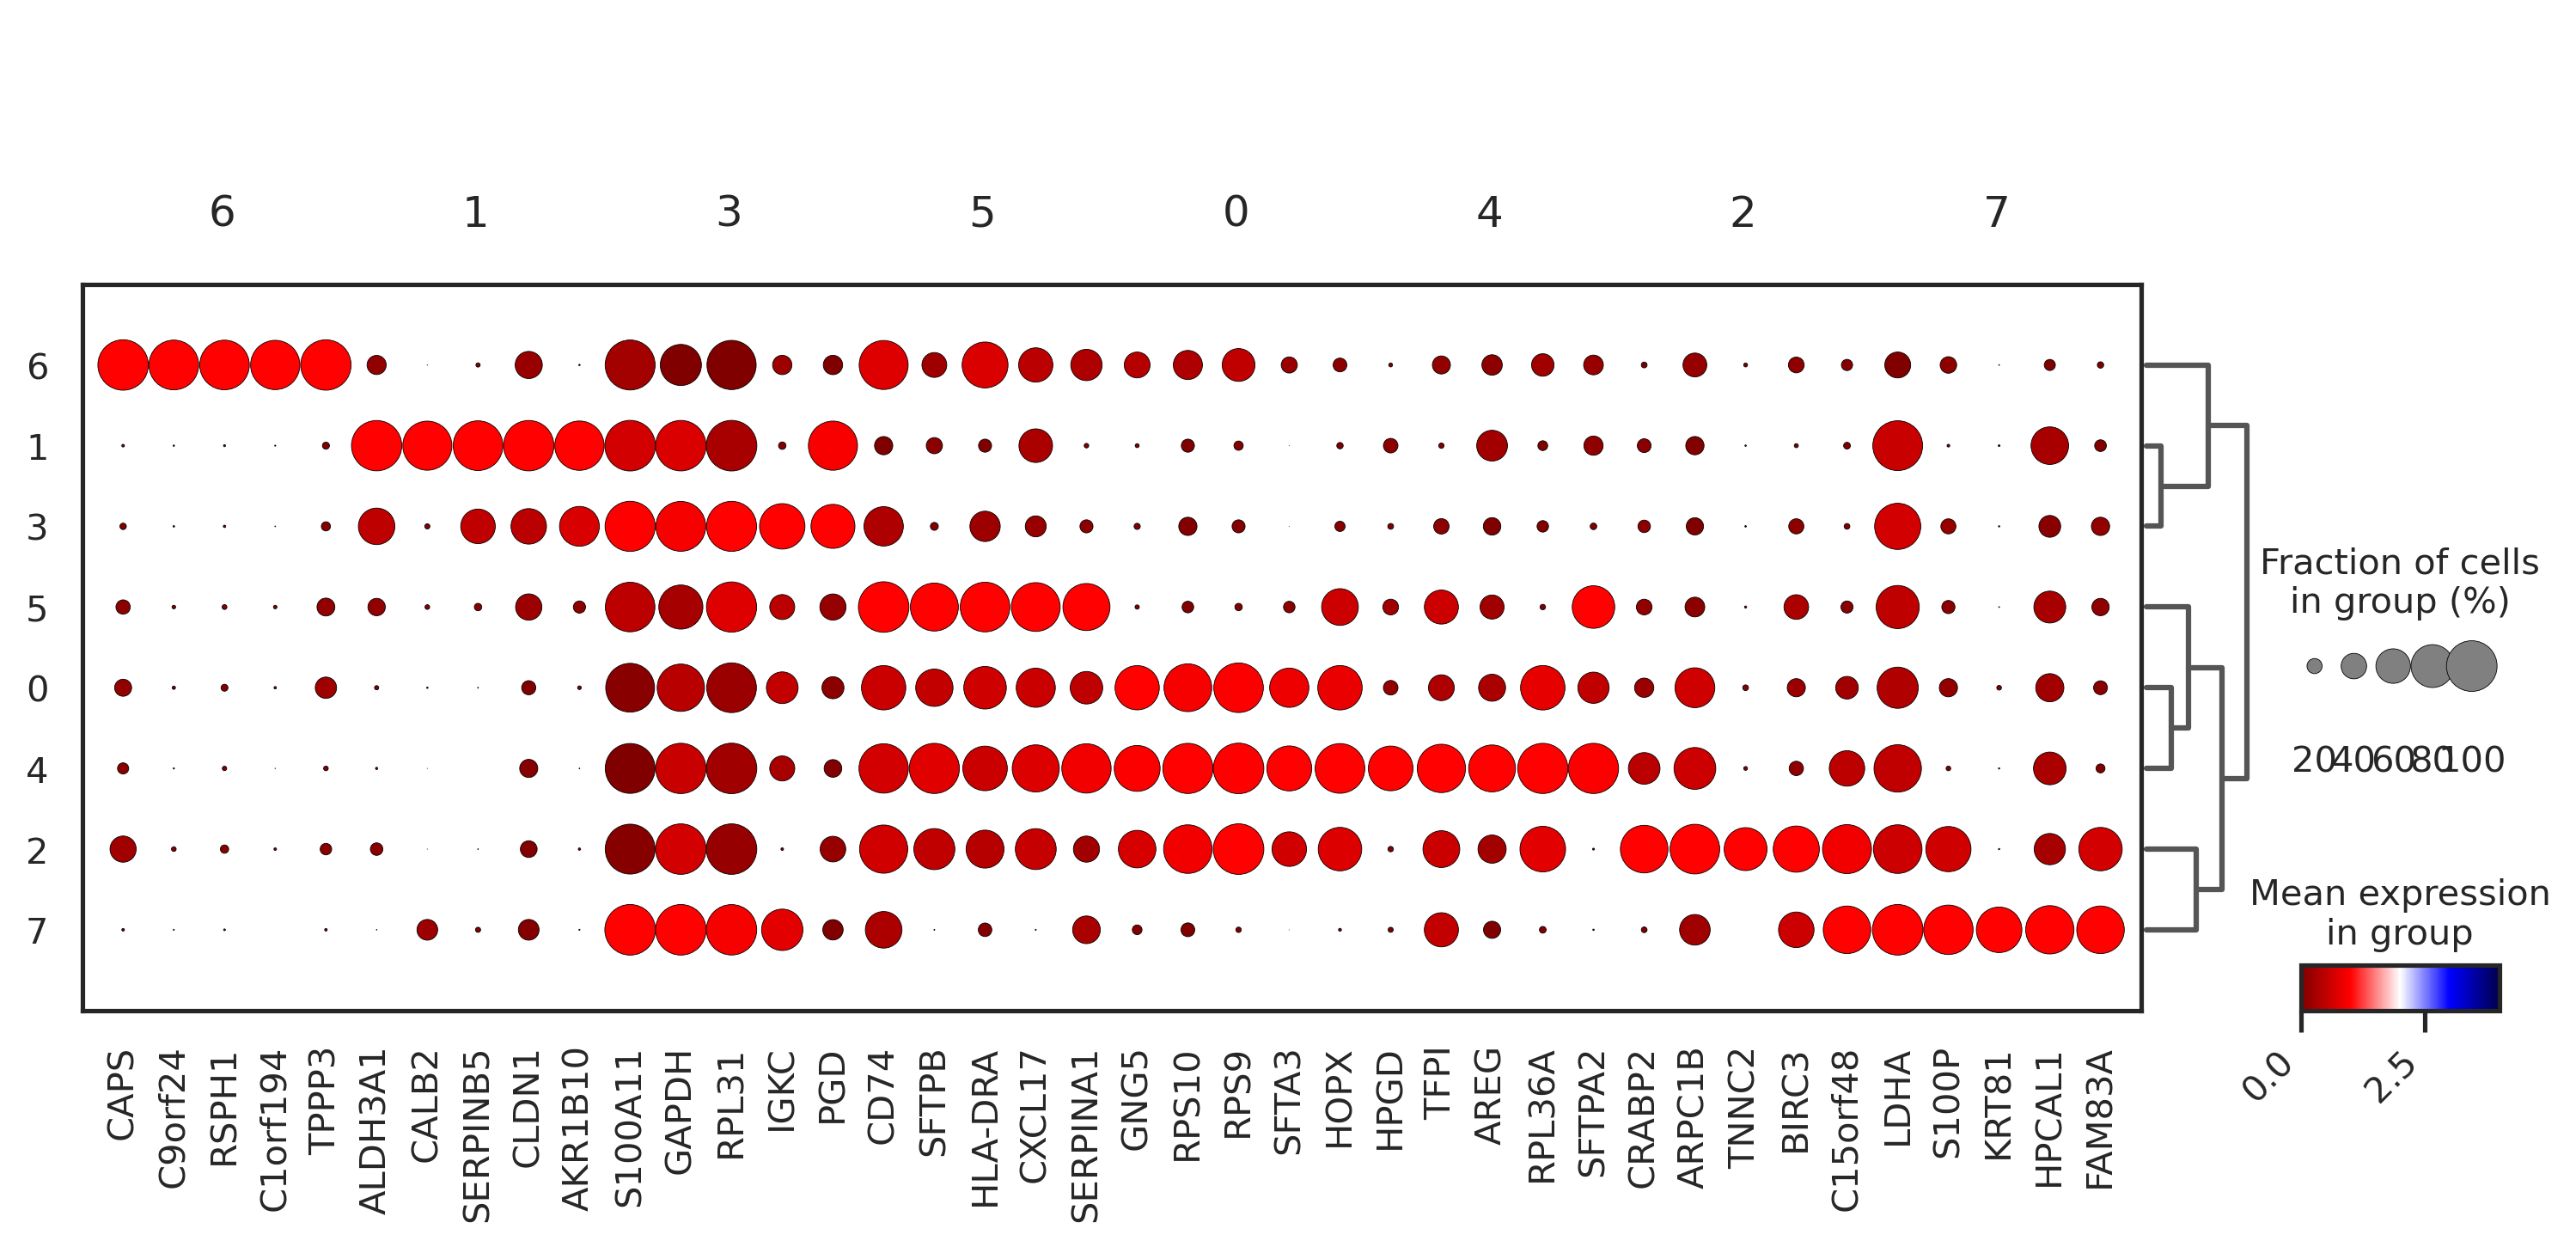

In [151]:
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,  groupby='leiden', n_genes=5, dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot_w2_suptype_INT.png", dpi=300)
plt.show()

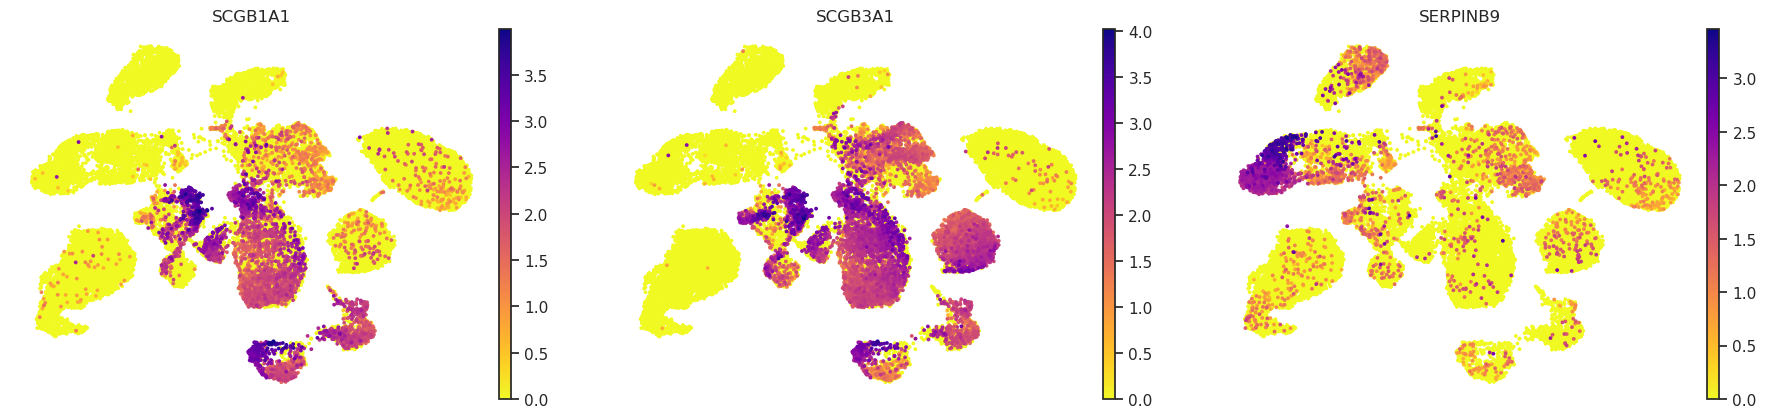

In [98]:
sc.pl.umap(adata, color=["SCGB1A1",'SCGB3A1','SERPINB9'], size=30, frameon=False, show=False, cmap="plasma_r")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [43]:
ranked_genes = adata.uns['rank_genes_groups']
top_genes = {}
for cluster in ranked_genes['names'].dtype.names:  
    top_genes[cluster] = ranked_genes['names'][cluster][:5]  
for cluster, genes in top_genes.items():
    print(f"Cluster {cluster}: {', '.join(genes)}")


Cluster 0: GNG5, RPS10, RPS9, SFTA3, HOPX
Cluster 1: ALDH3A1, CALB2, SERPINB5, CLDN1, AKR1B10
Cluster 2: CRABP2, ARPC1B, TNNC2, BIRC3, C15orf48
Cluster 3: S100A11, GAPDH, RPL31, IGKC, PGD
Cluster 4: HPGD, TFPI, AREG, RPL36A, SFTPA2
Cluster 5: CD74, SFTPB, HLA-DRA, CXCL17, SERPINA1
Cluster 6: CAPS, C9orf24, RSPH1, C1orf194, TPPP3
Cluster 7: LDHA, S100P, KRT81, HPCAL1, FAM83A


In [112]:
cluster_to_epithelial = {
    0: "Club",  
    1: "Progenitor",
    2: "Basal",
    3: "Hillock",  
    4: "Club",
    5: "Club",
    6: "Club",
    7: "Basal"
}

adata.obs['leiden'] = adata.obs['leiden'].astype(int)
adata.obs['epithelial'] = adata.obs['leiden'].map(cluster_to_epithelial)
adata.obs[['leiden', 'epithelial']].head()

leiden epithelial
BD_immune01_612637-0       3    Hillock
BD_immune01_698718-0       3    Hillock
BD_immune01_509246-0       3    Hillock
BD_immune01_101435-0       3    Hillock
BD_immune01_216465-0       3    Hillock

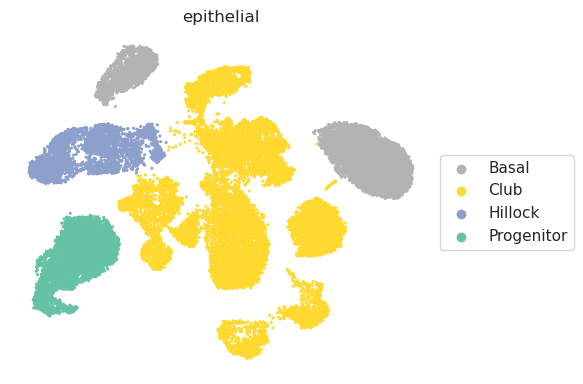

In [113]:
fig, ax = plt.subplots(figsize=(6, 4))  # Set figure size
sc.pl.umap(adata, color="epithelial", size=20, frameon=False, ax=ax, show=False,palette='Set2_r')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("epi_w_INT.png", dpi=300)
plt.show()

In [102]:
adata.obs['Sample_Origin'] = adata.obs['Sample_Origin'].cat.add_categories('Post_Treatment')

# Now assign 'Post_Treatment' to the rows where 'Sample_Origin' is NaN
adata.obs.loc[adata.obs['Sample_Origin'].isna(), 'Sample_Origin'] = 'Post_Treatment'
print(adata.obs['Sample_Origin'].unique())


['Post_Treatment', 'tLung', 'nLung', 'tL/B']
Categories (4, object): ['nLung', 'tL/B', 'tLung', 'Post_Treatment']


In [103]:
adata.obs['Sample_Origin'] = pd.Categorical(
    adata.obs['Sample_Origin'], 
    categories=['nLung', 'tLung', 'tL/B', 'Post_Treatment'], 
    
)
print(adata.obs['Sample_Origin'].unique()) 

['Post_Treatment', 'tLung', 'nLung', 'tL/B']
Categories (4, object): ['nLung', 'tLung', 'tL/B', 'Post_Treatment']


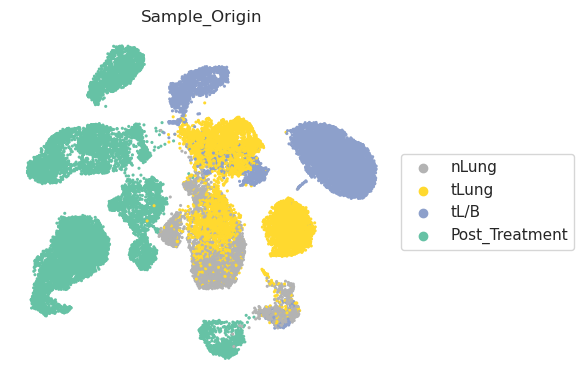

In [104]:
fig, ax = plt.subplots(figsize=(6, 4))  # Set figure size
sc.pl.umap(adata, color="Sample_Origin", size=20, frameon=False, ax=ax, show=False,palette='Set2_r')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("sample_w_INT.png", dpi=300)
plt.show()

In [105]:
file_path = 'gene_signatures.xlsx'
gene_set_df = pd.read_excel(file_path)
print(gene_set_df.head())

missing_genes = {}
for module in gene_set_df.columns:
    missing_genes[module] = [gene for gene in gene_set_df[module] if gene not in adata.var_names]

# Step 2: Display missing genes for each module
for module, genes in missing_genes.items():
    if genes:
        print(f"Missing genes in module {module}: {genes}")

# Step 3: Filter the gene lists to include only genes available in `adata.var_names`
for module in gene_set_df.columns:
    valid_genes = [gene for gene in gene_set_df[module] if gene in adata.var_names]
    
    if valid_genes:
        print(f"Scoring genes for module {module}...")
        sc.tl.score_genes(adata, gene_list=valid_genes, score_name=f"score_{module}", random_state=123456)
    else:
        print(f"No valid genes for module {module} available in the data.")

# Step 4: Verify the scores were added
print(adata.obs.columns)

  Club Henry et al. 2018 Hillock Henry et al. 2018 scNMF Club  \
0                SCGB3A1                     KRT13       SLPI   
1                   LCN2                     S100P      WFDC2   
2                   PIGR                  APOBEC3A     CRABP2   
3                   PSCA                     GDF15       ASS1   
4                  OLFM4                      CSTB     S100A6   

  scNMF senescent epithelium scNMF interferon signaling epithelium  \
0                       SLPI                               HLA-DRA   
1                      WFDC2                                  CD74   
2                     CRABP2                              HLA-DRB1   
3                       ASS1                              HLA-DPA1   
4                     S100A6                              HLA-DQB1   

  PMN-MDSC activity MDSC Hirz 2023 MDSC Calcinotto 2018  \
0             RPL21          CEBPB                 IL4R   
1              XAF1           IL10             TNFRSF17   
2          

In [106]:
modules = [
    'score_Club Henry et al. 2018',
    'score_Hillock Henry et al. 2018',
    'score_scNMF Club',
    'score_scNMF senescent epithelium',
    'score_scNMF interferon signaling epithelium',
    'score_PMN-MDSC activity',
    'score_MDSC Hirz 2023',
    'score_MDSC Calcinotto 2018',
    'score_BPECT Luminal Identity',
    'score_BPECT Basal Identity',
    'score_BPECT Club Identity',
    'score_BPECT Hillock Identity',
    'score_BPECT Neuroendocrine Identity',
    'score_Tang et al. CRPC-AR',
    'score_Tang et al. CRPC-WNT',
    'score_Tang et al. CRPC-NE',
    'score_Tang et al. CRPC-SCL',
    'score_scNMF senescent epithelium',
    'score_Kiviaho et al. scNMF Club interferon',
    'score_Kiviaho et al. scNMF Club'
]

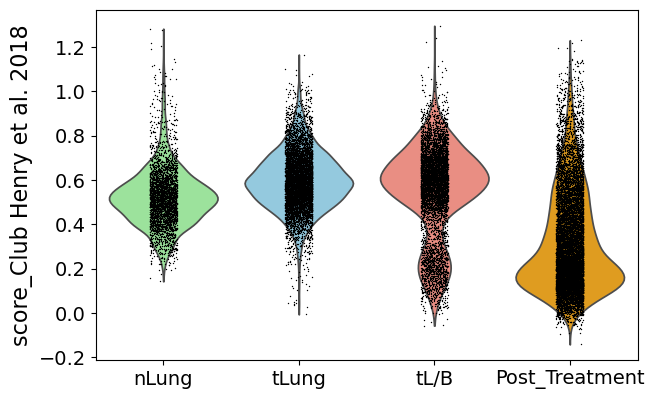

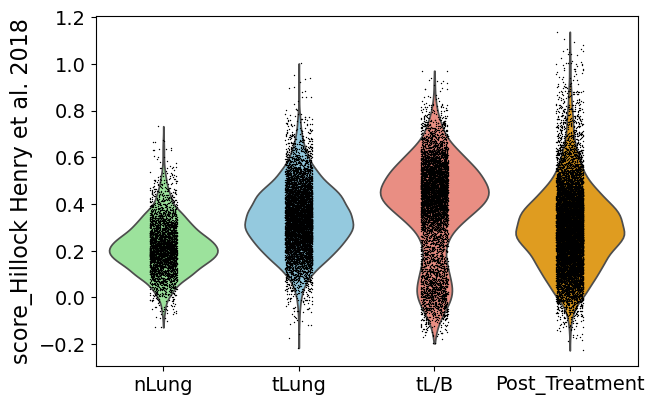

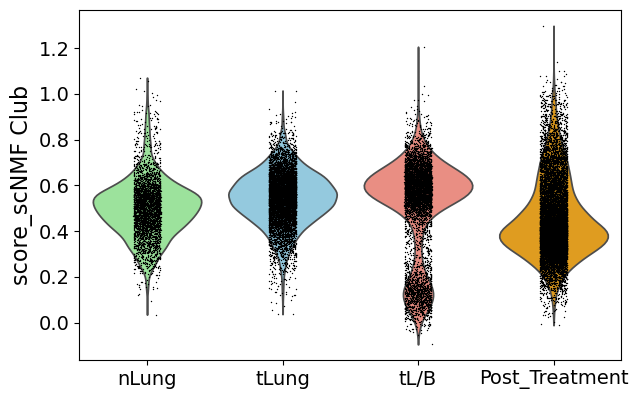

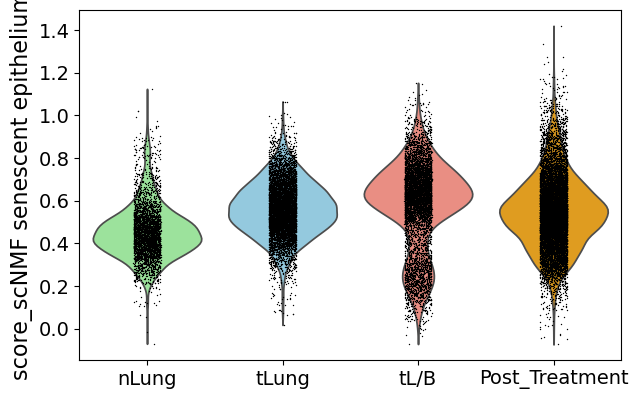

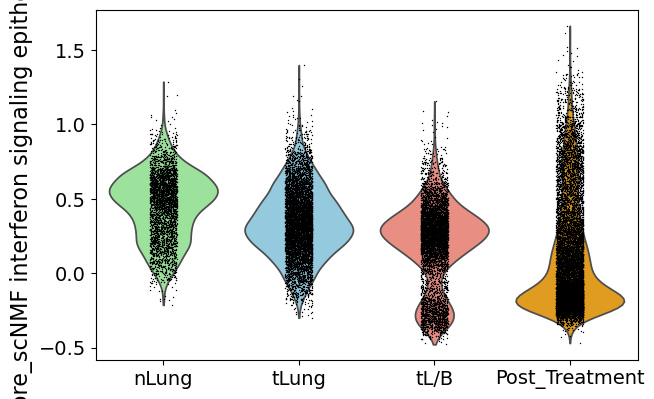

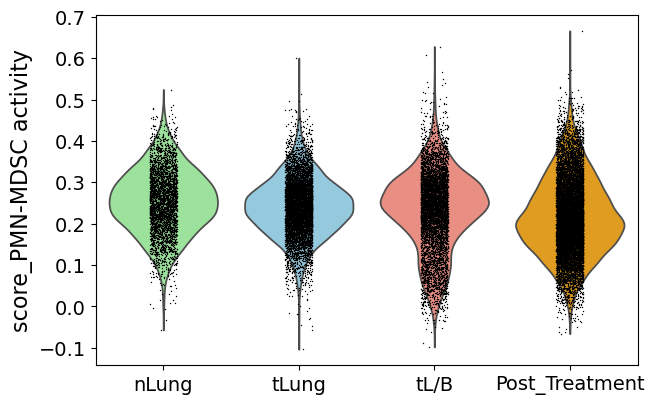

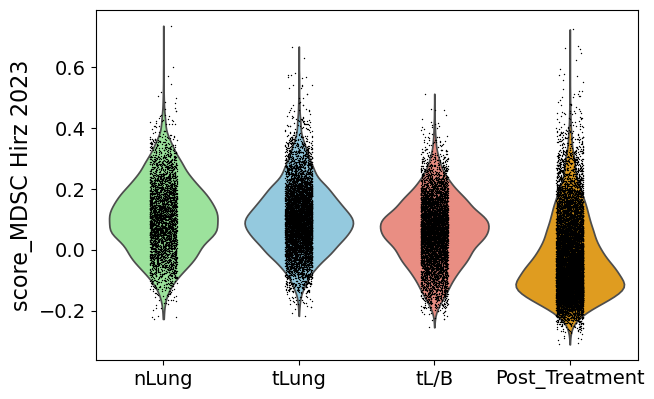

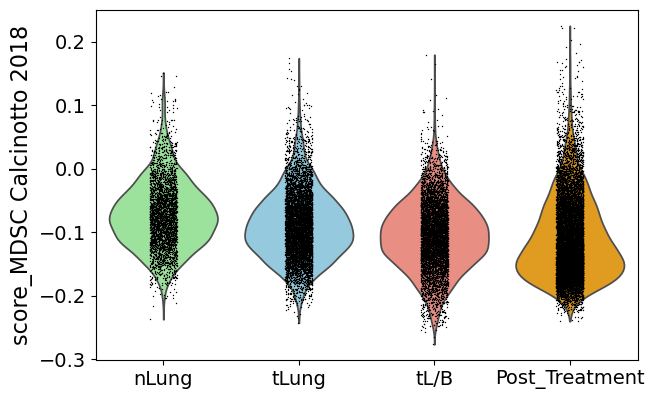

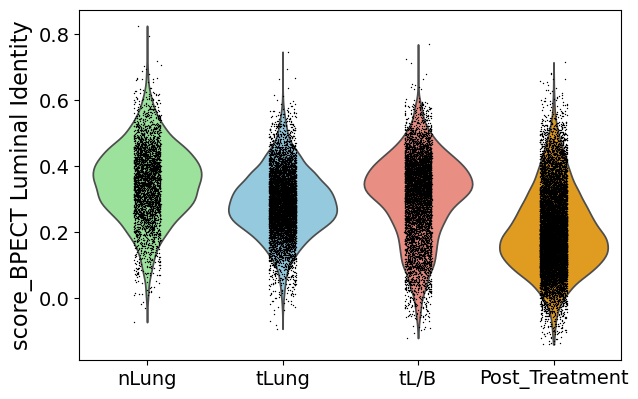

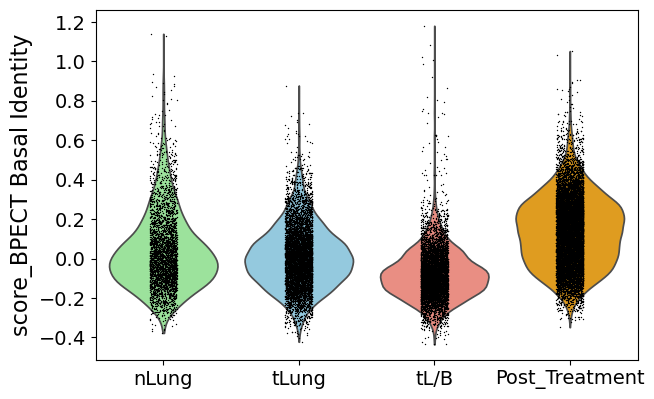

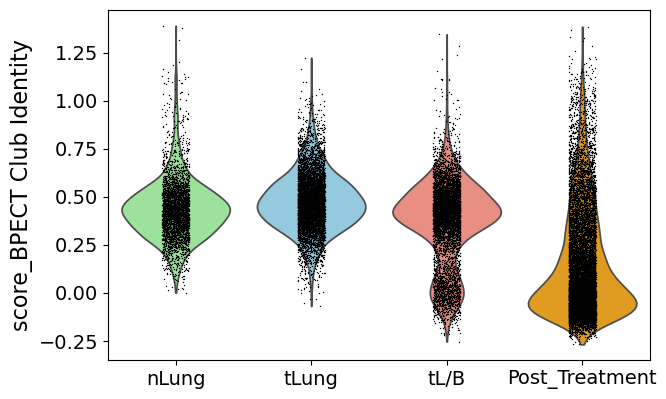

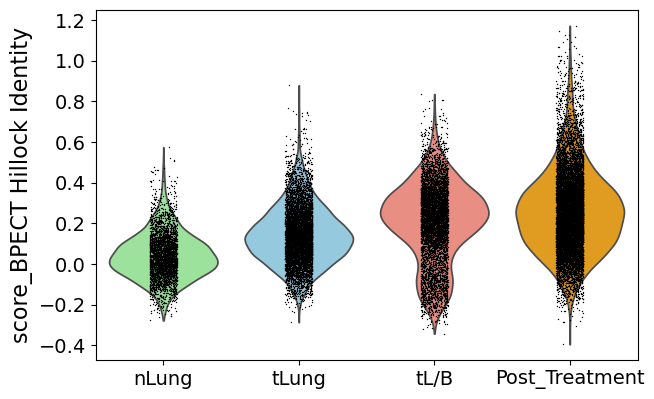

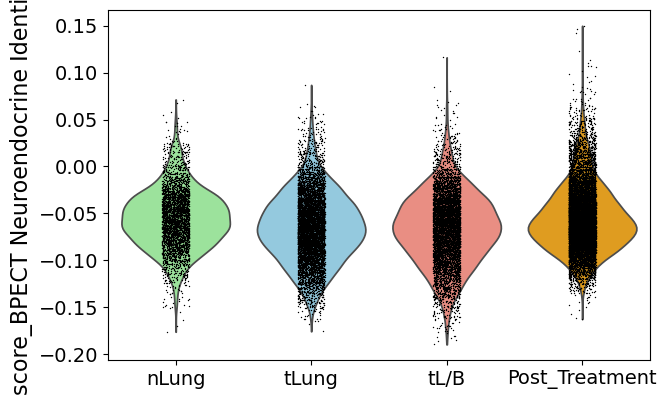

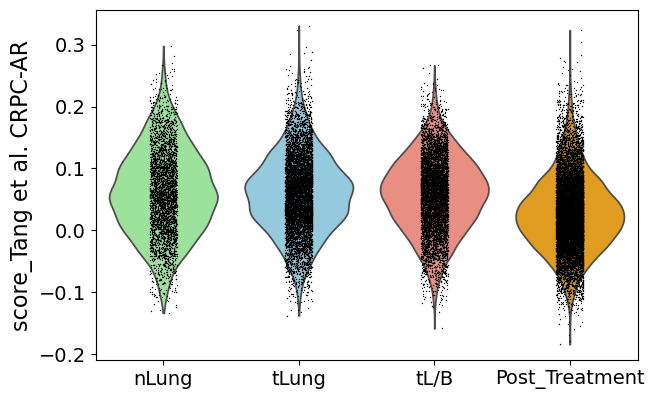

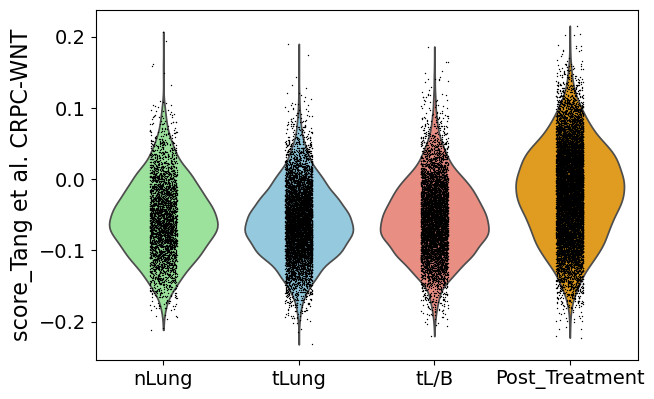

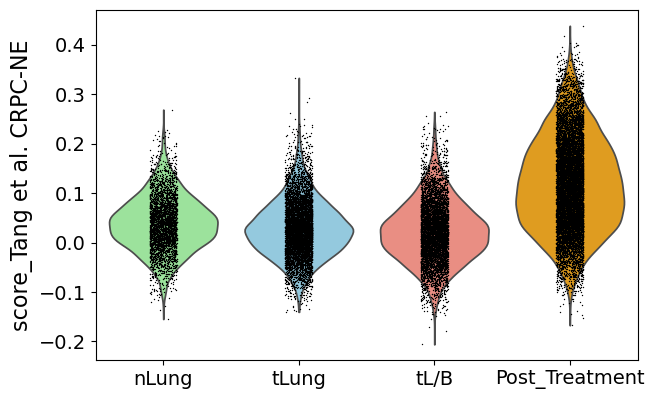

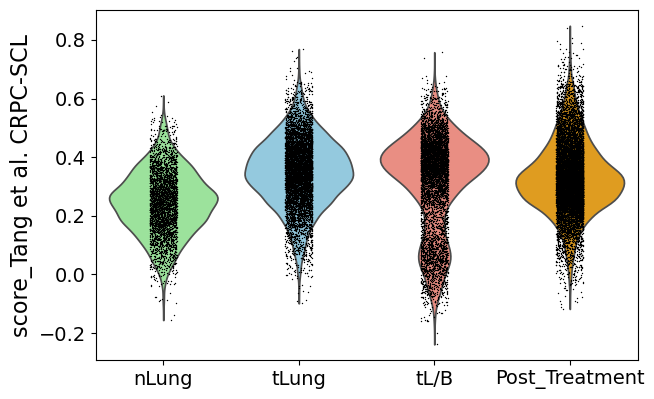

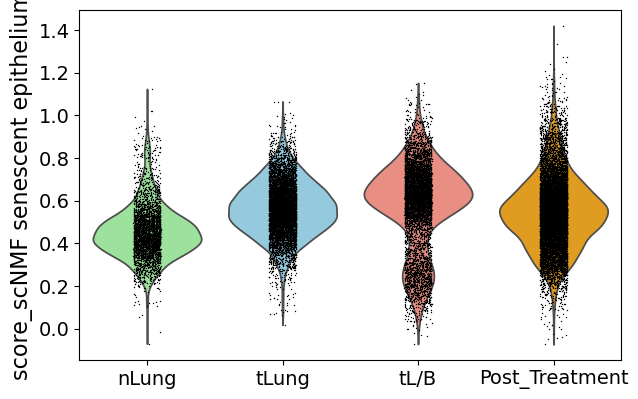

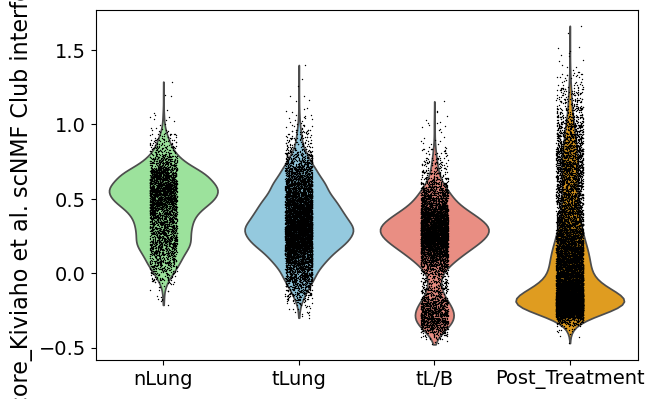

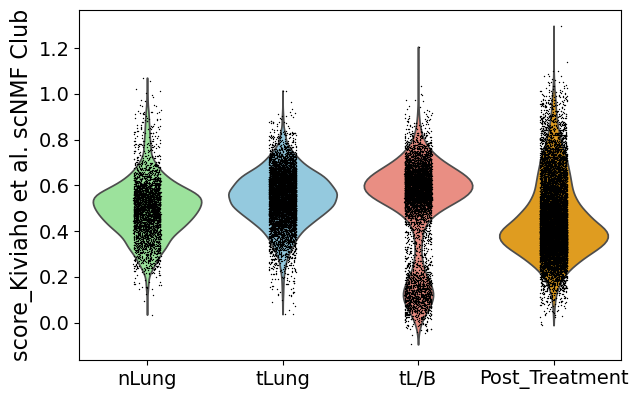

In [19]:
adata.obs['Sample_Origin'] = adata.obs['Sample_Origin'].astype('category')
for name in modules:
    sc.pl.violin(adata, keys=name,groupby='Sample_Origin', palette={'tLung': 'skyblue', 'nLung': 'lightgreen', 'tL/B': 'salmon','Post_Treatment': 'orange'}, 
                show=False)
    plt.xlabel("")
    plt.ylabel(name, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"SAMPLE_WITHO_{name.replace(' ', '_')}.png", dpi=300)
    plt.show()

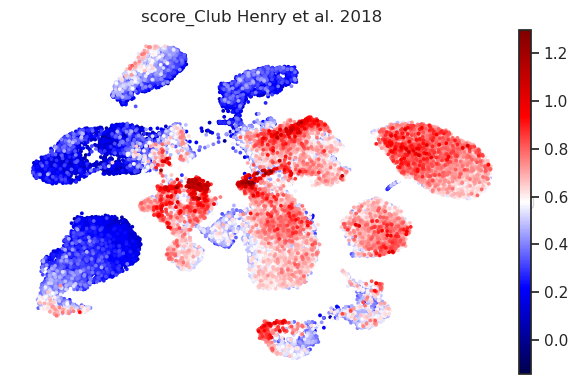

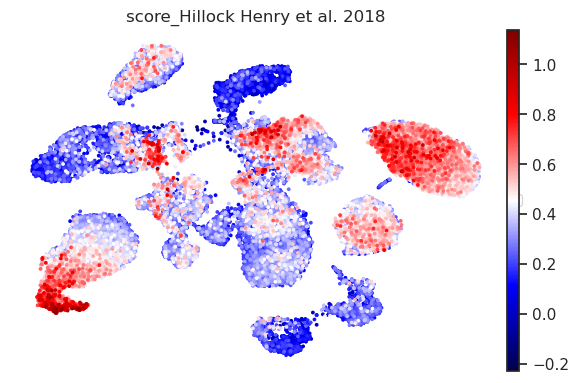

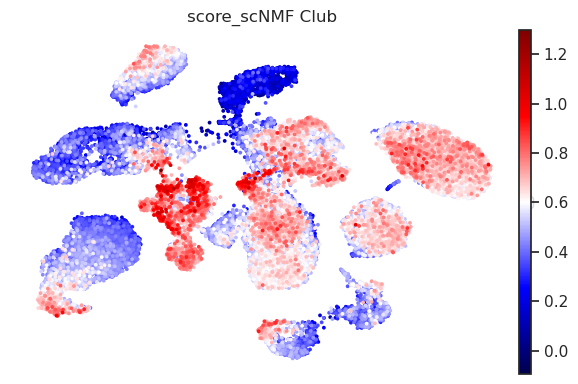

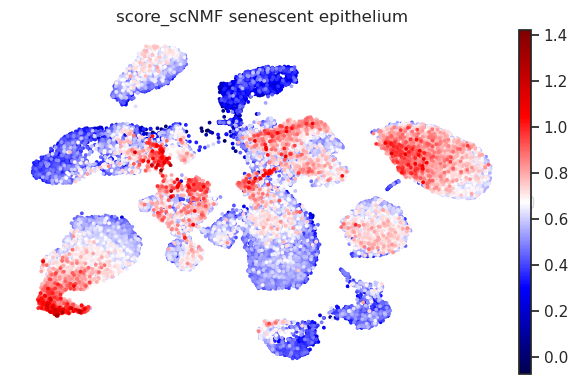

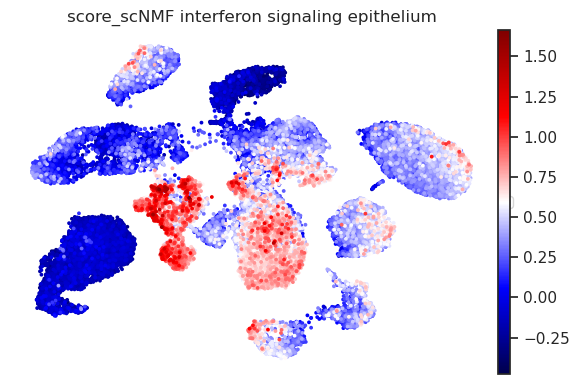

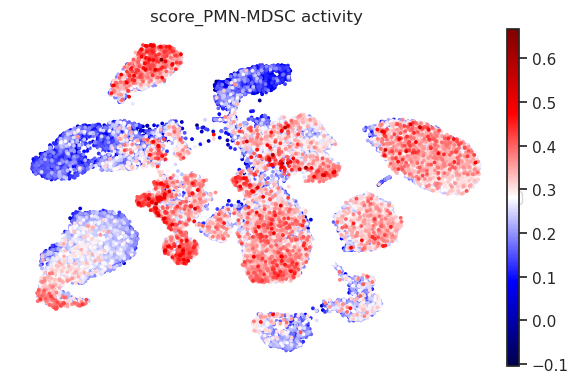

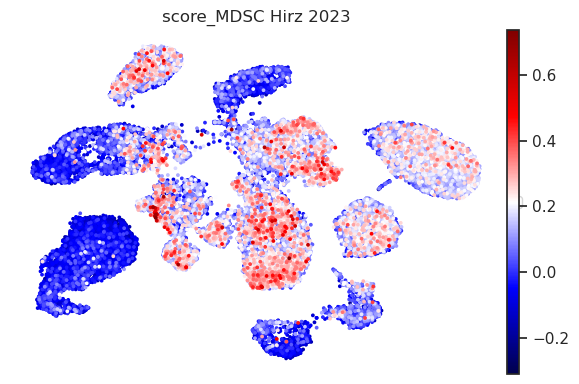

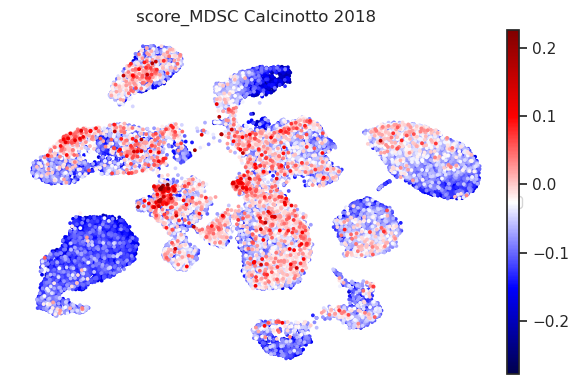

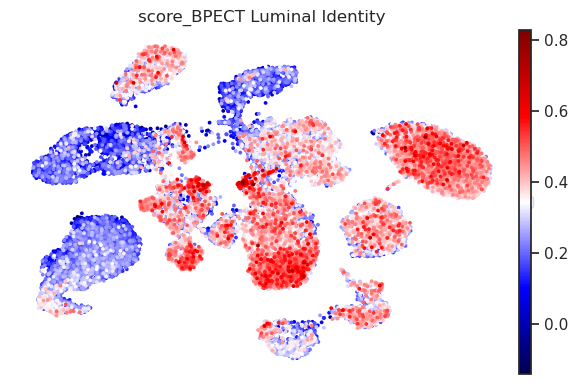

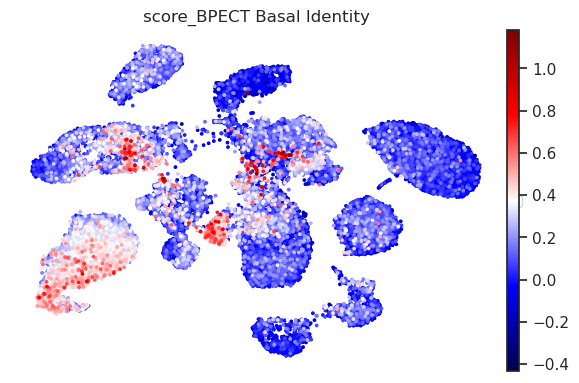

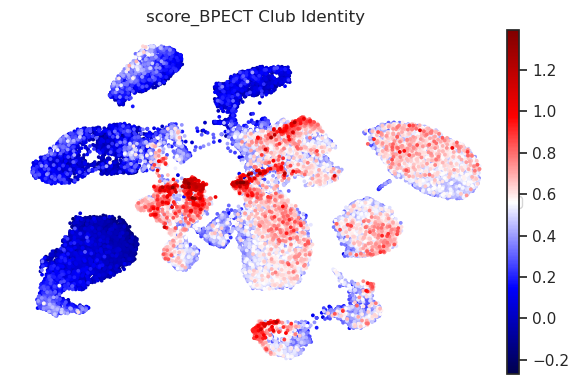

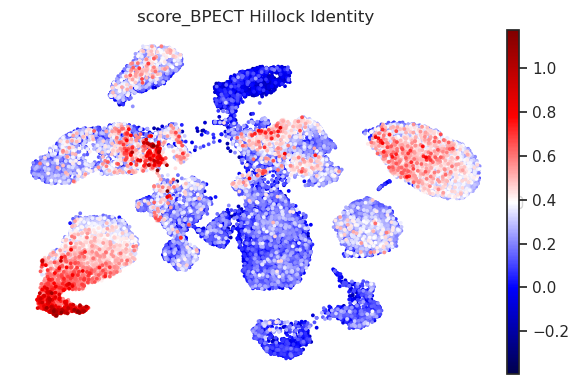

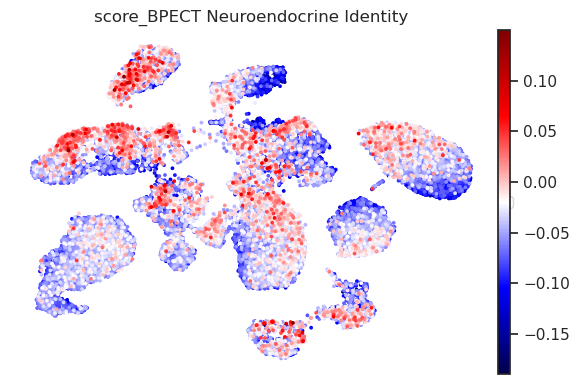

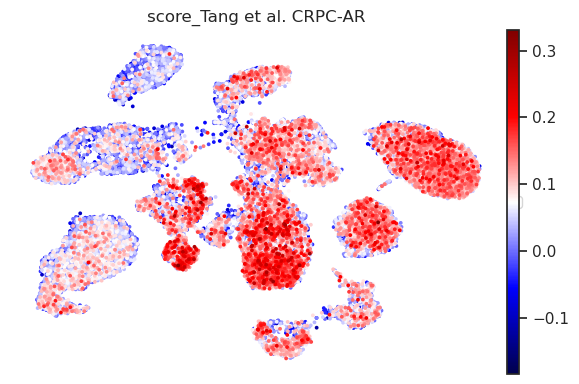

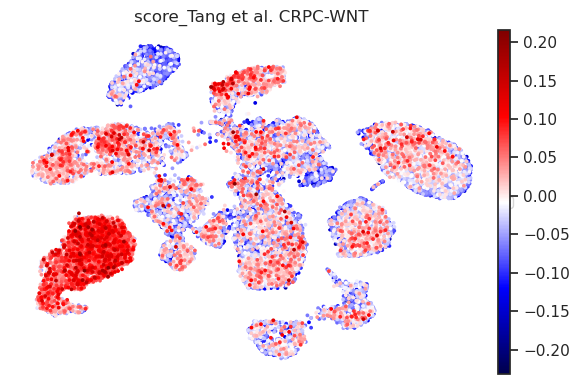

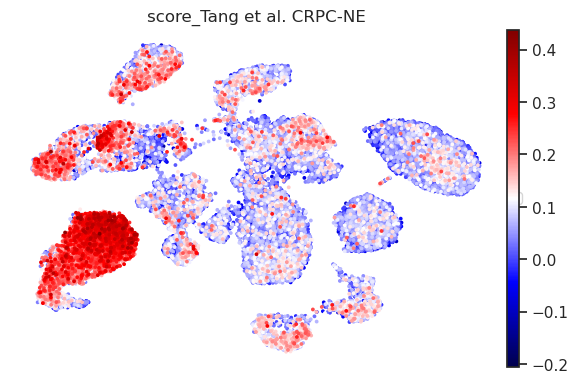

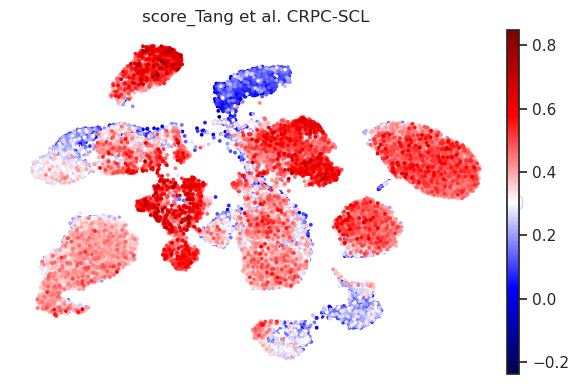

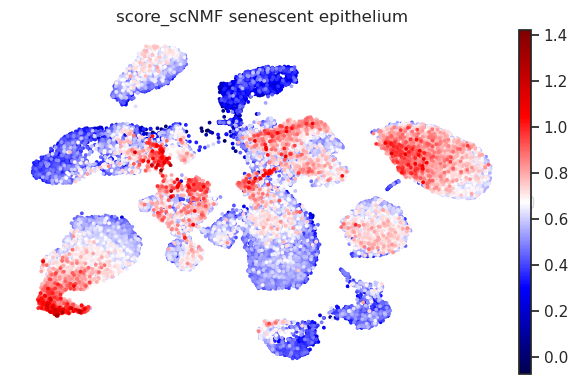

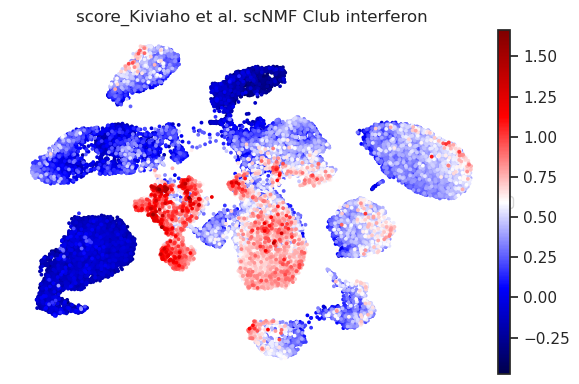

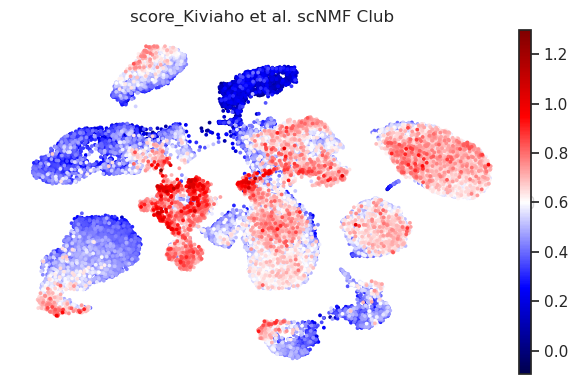

In [55]:
for name in modules:
    fig, ax = plt.subplots(figsize=(6, 4))  
    sc.pl.umap(adata, cmap= 'seismic', color=name, size=30, frameon=False, ax=ax, show=False)
    plt.ylabel(name, fontsize=12)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"W_UMAP_INT_{name.replace(' ', '_')}.png", dpi=300)
    plt.show()

In [107]:
adata.write("epithelial_w_INT.h5ad")

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Define the pairs to compare
pairs = [("nLung", "tLung"), ("nLung", "tL/B"), ("tLung", "tL/B"), 
         ("nLung", 'Post_Treatment'), ("tLung", 'Post_Treatment'), ("tL/B", 'Post_Treatment')]

# Extract relevant data
adata_df = adata.obs[['epithelial', 'Sample', 'Sample_Origin']].copy()

# Filter for Secretory (Club) and Secretory (Club) + Goblet cells
club_cells_data = adata_df[adata_df['epithelial'] == 'Club']

# Count club cells per sample
club_cells_counts = club_cells_data.groupby(['Sample']).size()
total_counts = adata_df.groupby(['Sample']).size()

# Calculate the percentage of Club cells for each sample
club_cells_pct = (club_cells_counts / total_counts) * 100

# Convert to DataFrame for easy manipulation
plot_data = club_cells_pct.reset_index()
plot_data.columns = ['Sample', 'Percentage']

# Merge with the Sample_Origin data
plot_data = plot_data.merge(adata.obs[['Sample', 'Sample_Origin']].drop_duplicates(), on='Sample')

# Ensure 'Sample_Origin' is categorical with correct order
plot_data['Sample_Origin'] = pd.Categorical(
    plot_data['Sample_Origin'], 
    categories=["nLung", "tLung", "tL/B", "Post_Treatment"], 
    ordered=True
)

# Store results for the p-values
p_values = []

# Perform pairwise Wilcoxon rank-sum tests (Mann-Whitney U test)
for g1, g2 in pairs:
    group1 = plot_data[plot_data['Sample_Origin'] == g1]['Percentage']
    group2 = plot_data[plot_data['Sample_Origin'] == g2]['Percentage']
    
    if len(group1) > 0 and len(group2) > 0:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        p_values.append((g1, g2, p))

# Convert p-values to DataFrame
p_values_df = pd.DataFrame(p_values, columns=["Group1", "Group2", "P-value"])

# Apply multiple testing correction (Bonferroni)
p_values_df["Adjusted P-value"] = multipletests(p_values_df["P-value"], method="bonferroni")[1]

# Print adjusted p-values
print("\nAdjusted p-values (Bonferroni correction):")
print(p_values_df)




Adjusted p-values (Bonferroni correction):
  Group1          Group2   P-value  Adjusted P-value
0  nLung           tLung  0.363302          1.000000
1  nLung            tL/B  0.131668          0.790008
2  tLung            tL/B  0.439882          1.000000
3  nLung  Post_Treatment  0.000216          0.001297
4  tLung  Post_Treatment  0.000386          0.002313
5   tL/B  Post_Treatment  0.155027          0.930159


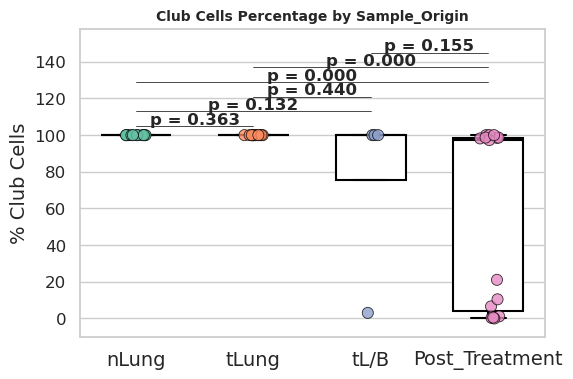

In [145]:

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Define color palette
sample_palette = sns.color_palette("Set2", n_colors=len(plot_data['Sample_Origin'].cat.categories))

ax = sns.boxplot(data=plot_data, x='Sample_Origin', y='Percentage', 
                 width=0.6, linewidth=1.5, fliersize=0,  
                 boxprops=dict(facecolor='white', edgecolor='black'),
                 whiskerprops=dict(color="black"),
                 capprops=dict(color="black"),
                 medianprops=dict(color="black"),
                 zorder=1)



sns.stripplot(data=plot_data, x='Sample_Origin', y='Percentage', 
              palette=sample_palette, jitter=True, size=8, alpha=0.8, edgecolor="black", linewidth=0.6, zorder=2)

# **Correctly position p-values above the correct boxes**
y_max = plot_data["Percentage"].max() + 5  
x_positions = {category: i for i, category in enumerate(plot_data['Sample_Origin'].cat.categories)}

for (g1, g2, p) in p_values:
    x1, x2 = x_positions[g1], x_positions[g2]  # Correctly get x-axis positions
    plt.plot([x1, x2], [y_max, y_max], color="black", linewidth=0.5)
    plt.text((x1 + x2) / 2, y_max + 1, f"p = {p:.3f}", ha='center', fontsize=12, fontweight="bold")
    y_max += 8  

plt.title("Club Cells Percentage by Sample_Origin", fontsize=10, fontweight="bold")
plt.xlabel("")
plt.ylabel("% Club Cells", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10, y_max + 5)  
plt.savefig("percentage_club_w_INT.png", dpi=300)
plt.show()

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Define the pairs to compare
pairs = [("nLung", "tLung"), ("nLung", "tL/B"), ("tLung", "tL/B"), 
         ("nLung", 'Post_Treatment'), ("tLung", 'Post_Treatment'), ("tL/B", 'Post_Treatment')]

# Extract relevant data
adata_df = adata.obs[['epithelial', 'Sample', 'Sample_Origin']].copy()

# Filter for Secretory (Club) and Secretory (Club) + Goblet cells
club_cells_data = adata_df[adata_df['epithelial'] == 'Hillock']

# Count club cells per sample
club_cells_counts = club_cells_data.groupby(['Sample']).size()
total_counts = adata_df.groupby(['Sample']).size()

# Calculate the percentage of Club cells for each sample
club_cells_pct = (club_cells_counts / total_counts) * 100

# Convert to DataFrame for easy manipulation
plot_data = club_cells_pct.reset_index()
plot_data.columns = ['Sample', 'Percentage']

# Merge with the Sample_Origin data
plot_data = plot_data.merge(adata.obs[['Sample', 'Sample_Origin']].drop_duplicates(), on='Sample')

# Ensure 'Sample_Origin' is categorical with correct order
plot_data['Sample_Origin'] = pd.Categorical(
    plot_data['Sample_Origin'], 
    categories=["nLung", "tLung", "tL/B", "Post_Treatment"], 
    ordered=True
)

# Store results for the p-values
p_values = []

# Perform pairwise Wilcoxon rank-sum tests (Mann-Whitney U test)
for g1, g2 in pairs:
    group1 = plot_data[plot_data['Sample_Origin'] == g1]['Percentage']
    group2 = plot_data[plot_data['Sample_Origin'] == g2]['Percentage']
    
    if len(group1) > 0 and len(group2) > 0:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        p_values.append((g1, g2, p))

# Convert p-values to DataFrame
p_values_df = pd.DataFrame(p_values, columns=["Group1", "Group2", "P-value"])

# Apply multiple testing correction (Bonferroni)
p_values_df["Adjusted P-value"] = multipletests(p_values_df["P-value"], method="bonferroni")[1]

# Print adjusted p-values
print("\nAdjusted p-values (Bonferroni correction):")
print(p_values_df)




Adjusted p-values (Bonferroni correction):
  Group1          Group2   P-value  Adjusted P-value
0  nLung           tLung  1.000000          1.000000
1  nLung            tL/B  1.000000          1.000000
2  tLung            tL/B  1.000000          1.000000
3  nLung  Post_Treatment  0.000216          0.001297
4  tLung  Post_Treatment  0.000216          0.001297
5   tL/B  Post_Treatment  0.015955          0.095732


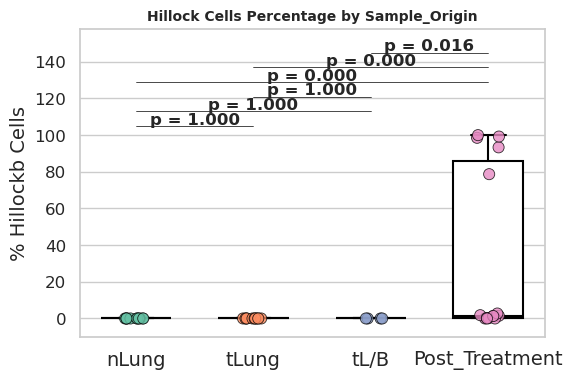

In [147]:

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Define color palette
sample_palette = sns.color_palette("Set2", n_colors=len(plot_data['Sample_Origin'].cat.categories))

ax = sns.boxplot(data=plot_data, x='Sample_Origin', y='Percentage', 
                 width=0.6, linewidth=1.5, fliersize=0,  
                 boxprops=dict(facecolor='white', edgecolor='black'),
                 whiskerprops=dict(color="black"),
                 capprops=dict(color="black"),
                 medianprops=dict(color="black"),
                 zorder=1)



sns.stripplot(data=plot_data, x='Sample_Origin', y='Percentage', 
              palette=sample_palette, jitter=True, size=8, alpha=0.8, edgecolor="black", linewidth=0.6, zorder=2)

# **Correctly position p-values above the correct boxes**
y_max = plot_data["Percentage"].max() + 5  
x_positions = {category: i for i, category in enumerate(plot_data['Sample_Origin'].cat.categories)}

for (g1, g2, p) in p_values:
    x1, x2 = x_positions[g1], x_positions[g2]  # Correctly get x-axis positions
    plt.plot([x1, x2], [y_max, y_max], color="black", linewidth=0.5)
    plt.text((x1 + x2) / 2, y_max + 1, f"p = {p:.3f}", ha='center', fontsize=12, fontweight="bold")
    y_max += 8  

plt.title("Hillock Cells Percentage by Sample_Origin", fontsize=10, fontweight="bold")
plt.xlabel("")
plt.ylabel("% Hillockb Cells", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10, y_max + 5)  
plt.savefig("percentage_hillock_w_INT.png", dpi=300)
plt.show()